In [1]:
# Operating System
import os

#Pandas and Numpy
import pandas as pd
import numpy as np

#ramdom generator
import random

#Plots
import matplotlib.pyplot as plt
%matplotlib inline

# Statistics
from scipy.stats import binom_test

# Strings
import re

In [2]:
def ends(df, x=5):
    return df.head(x).append(df.tail(x))

# Load original data

In [3]:
#file_path = ".\data\train.csv"
file_path = os.path.join('data', 'train.csv')


# # Option 1 for reading a sample of the file
# n_total_rows = 2437645
# prc_rows_to_read = 10
# n_rows_to_read = int(prc_rows_to_read/100*n_total_rows)
# n_rows_to_skip = n_total_rows - n_rows_to_read

# random.seed(178) # this is to get always the same sample. can be removed if we want the sample to change

# list_of_rows_to_skip = random.sample(
#     range(1, n_total_rows-1), # this is a range from the first row after the header, to the last row on the file
#     n_rows_to_skip # this is the number of rows we want to sample, i.e, to skip
# )


# Option 2 for reading a sample of the file
# sample 20% of the rows
p = 1

random.seed(178)  # this is to get always the same sample. can be removed if we want the sample to change
try:
    df_original = pd.read_csv(file_path, 
                             skiprows = lambda row_num: random.random() > p and row_num > 0, 
                             #nrows = 10000, 
                             header=0,
                             warn_bad_lines=True)
except:
    print('Ooops!!! We got an error!')


# Transform data to analysis

In [4]:
remane_columns_dict = {'VehicleSearchedIndicator': 'search', 
                       'ContrabandIndicator': 'target', 
                       'Department Name': 'departm',
                       'InterventionDateTime': 'date',
                       'InterventionLocationName': 'local',
                       'InterventionReasonCode': 'reason',
                       'ReportingOfficerIdentificationID': 'officerID',
                       'ResidentIndicator': 'state_res',
                       'SearchAuthorizationCode': 'search_reason',
                       'StatuteReason': 'stop_reason',
                       'SubjectAge': 'age',
                       'SubjectEthnicityCode': 'ethnic',
                       'SubjectRaceCode': 'race',
                       'SubjectSexCode': 'sex',
                       'TownResidentIndicator': 'town_res'
                      }

In [5]:
def simple_clean(doc, regex_list=[("[\.\?\(\)\|:;_!@/*\-]", " "), (" +", " ")] ):
    
    # Make sure it is a string!
    doc = str(doc)
    
    # remove or replace characters
    for regex in regex_list:
        doc = re.sub(regex[0], regex[1], doc)
    # lowercase
    doc = doc.lower()
    # Trim
    doc = doc.strip()
    # tokenize
    #words = tokenizer.tokenize(doc)
    # remove punctuation
    #words = list(filter(lambda x: x not in string.punctuation, words))
    # stem
    #stems = list(map(stemmer.stem, words))
    #new_doc = " ".join(stems)
    new_doc = doc
    return new_doc

In [6]:
simple_clean("    North@ /* -  America . ?  )  ; !     north- america   ")

'north america north america'

In [7]:
def data_transformer(df_original: pd.DataFrame, columns_dict: dict) -> pd.DataFrame:
    """Transforms the original DataFrame to make it suited for data analysis.
    
    Args:
        df_original (pd.DataFrame):  Original DataFrame, as imported by pd.read_csv().
        columns_dict (dict): Correspondence between old a new column names.
        
    Returns:
        df (pd.DataFrame): Transformed DataFrame, ready for data analysis.
        
    TODO:
        * to do list
        
    """
    
    df = df_original.copy()
    
    # change column names
    df = df.rename(columns = columns_dict)
    
    # convert date to pd.datetime
    df.date = pd.to_datetime(df.date)
    
    # Clean strings from special characters and multiple spaces
    df.local = df.local.apply(simple_clean)
    df.departm = df.departm.apply(simple_clean)
    df.stop_reason = df.stop_reason.apply(simple_clean)
    
    # convert Intervention DateTime to index of the DataFrame
    #df = df.set_index('date').sort_index()
    
   
    return df

df = data_transformer(df_original, remane_columns_dict)

# Dataframe and useful variables

In [8]:
dfs = df[df.search==True].reset_index()
dfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76743 entries, 0 to 76742
Data columns (total 16 columns):
index            76743 non-null int64
search           76743 non-null bool
target           76743 non-null bool
departm          76743 non-null object
date             76743 non-null datetime64[ns]
local            76743 non-null object
reason           76743 non-null object
officerID        76743 non-null object
state_res        76743 non-null bool
search_reason    76733 non-null object
stop_reason      76743 non-null object
age              76743 non-null float64
ethnic           76743 non-null object
race             76743 non-null object
sex              76743 non-null object
town_res         76743 non-null bool
dtypes: bool(4), datetime64[ns](1), float64(1), int64(1), object(9)
memory usage: 7.3+ MB


In [9]:
target_global_mean = dfs.target.mean()
target_global_mean

0.3325124115554513

In [10]:
n = dfs.shape[0]
n

76743

In [11]:
dfs.shape[0]/df.local.nunique()

51.162

## Police Department ('Department Name': 'departm',)

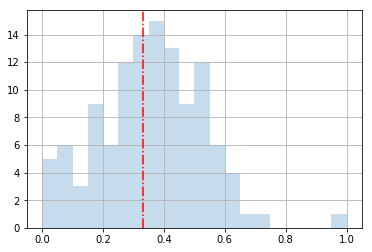

In [12]:
dfs.groupby('departm').target.mean().hist(bins=20, alpha=0.25)
plt.axvline(x=target_global_mean, color='r', linestyle='-.');

Group data by police department.

In [13]:
dfs_by_departm = dfs.groupby('departm').target.agg(['mean','count', 'sum']).sort_values('mean')

p-value the test: department average == global average 

In [14]:
dfs_by_departm['binom_test_p'] = dfs_by_departm.apply(lambda x: binom_test(x['sum'], x['count'], p=target_global_mean), axis=1)

Preview a sample of the data.

In [15]:
dfs_by_departm.sample(10, random_state=42).sort_values('mean')

,mean,count,sum,binom_test_p
departm,,,,
plainfield,0.042146,261,11.0,8.496280e-31
new haven,0.097883,5006,490.0,4.940656e-324
capitol police,0.111111,18,2.0,4.731230e-02
willimantic,0.282946,774,219.0,3.289051e-03
csp troop h,0.312018,907,283.0,1.924730e-01
orange,0.314286,175,55.0,6.312462e-01
csp troop a,0.337925,1089,368.0,6.996716e-01
east hartford,0.411624,1669,687.0,1.541906e-11
csp troop l,0.462094,554,256.0,2.854759e-10


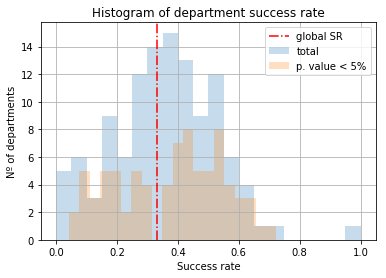

In [16]:
dfs.groupby('departm').target.mean().hist(bins=20, alpha=0.25, label='total')
dfs_by_departm.loc[dfs_by_departm.binom_test_p < 0.05, 'mean'].hist(bins=20, alpha=0.25, label='p. value < 5%')

plt.axvline(x=target_global_mean, color='r', linestyle='-.', label='global SR')

plt.title('Histogram of department success rate')
plt.xlabel("Success rate")
plt.ylabel("Nº of departments")

plt.legend()

plt.savefig(os.path.join('plots', 'target_departm_average_hist.png'));

In [17]:
pctl = (np.array(list(range(1,9,1)) + list(range(10,90,10)) + list(range(91,99,1)))*0.01).round(decimals=2).tolist()
#pctl = (np.array( list(range(0,100,1)))*0.01).round(decimals=2).tolist()
#df.departm.value_counts().describe(percentiles=pctl)

dfs_by_departm['count'].describe(percentiles=pctl)

count     117.000000
mean      655.923077
std       831.752742
min         1.000000
1%          1.000000
2%          1.320000
3%          2.960000
4%          4.640000
5%          8.200000
6%         17.640000
7.0%       22.120000
8%         24.120000
10%        41.200000
20%       103.200000
30%       131.600000
40%       265.400000
50%       472.000000
60%       572.600000
70%       753.200000
80%      1047.000000
91%      1576.000000
92%      1587.720000
93%      1659.280000
94%      1760.080000
95%      1832.800000
96%      2151.280000
97%      2365.840000
98%      2649.480000
max      5449.000000
Name: count, dtype: float64

In [18]:
(dfs_by_departm['binom_test_p'] < 0.05).sum()

80

In [19]:
(dfs_by_departm['binom_test_p'] >= 0.05).sum()

37

In [20]:
dfs.departm.nunique()

117

In [21]:
dfs_by_departm[dfs_by_departm['count'] == 1]

,mean,count,sum,binom_test_p
departm,,,,
wcsu,0.0,1,0.0,1.000000
ecsu,0.0,1,0.0,1.000000
met dist water authority,1.0,1,1.0,0.332512


<font color=red> **Try to estimate the standard deviation for each department (based on the sample size and target found) and filter if standar deviation higher than a given value, 0.1 for example.** </font>

## Search Location ('InterventionLocationName': 'local')

In [22]:
dfs_by_local = dfs.groupby('local').target.agg(['mean','count', 'sum']).sort_values('mean')

In [23]:
dfs_by_local['binom_test_p'] = dfs_by_local.apply(lambda x: binom_test(x['sum'], x['count'], p=target_global_mean), axis=1)

dfs_by_local.sample(10,  random_state=42).sort_values('mean')

,mean,count,sum,binom_test_p
local,,,,
419,0.000000,1,0.0,1.000000e+00
bridgeport,0.149666,2245,336.0,4.143100e-86
easton,0.227273,22,5.0,3.695348e-01
meriden,0.309603,604,187.0,2.436740e-01
killingly,0.425068,367,156.0,2.445408e-04
cheshire,0.430518,367,158.0,9.979633e-05
bloomfield,0.464037,431,200.0,1.556096e-08
north stonington,0.527027,74,39.0,7.331848e-04
east haddam,0.578125,64,37.0,8.331940e-05


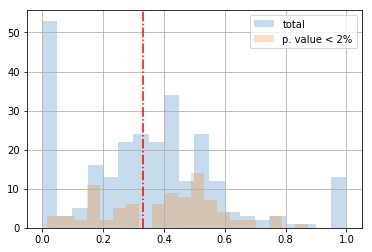

In [24]:
dfs.groupby('local').target.mean().hist(bins=20, alpha=0.25, label='total')
dfs_by_local.loc[dfs_by_local.binom_test_p < 0.02, 'mean'].hist(bins=20, alpha=0.25, label='p. value < 2%')
plt.axvline(x=target_global_mean, color='r', linestyle='-.')
plt.legend();

In [25]:
dfs.groupby('local').target.count().sort_values(ascending=False).describe()

count     267.000000
mean      287.426966
std       606.121136
min         1.000000
25%         3.000000
50%        44.000000
75%       252.500000
max      5799.000000
Name: target, dtype: float64

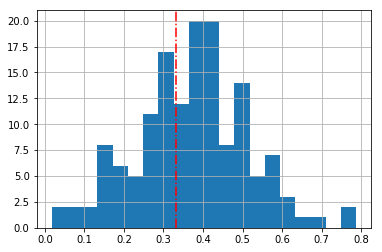

In [26]:
(dfs.groupby('local')
    .filter(lambda x: x.shape[0]>30)
    .groupby('local')
    .target.mean()
).hist(bins=20)
plt.axvline(x=target_global_mean, color='r', linestyle='-.');

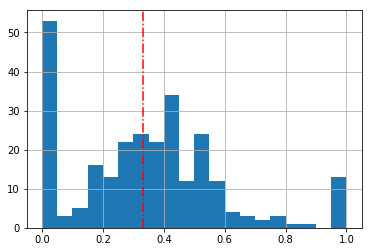

In [27]:
dfs.groupby('local').target.mean().hist(bins=20)
plt.axvline(x=target_global_mean, color='r', linestyle='-.');

### Search Officer ID

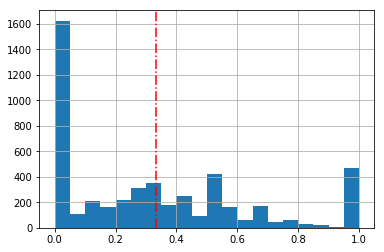

In [28]:
dfs.groupby('officerID').target.mean().hist(bins=20)
plt.axvline(x=target_global_mean, color='r', linestyle='-.');

In [29]:
pctl = (np.array([5] + list(range(10,90,10)) + list(range(91,99,1)))*0.01).round(decimals=2).tolist()
#pctl = (np.array( list(range(0,100,1)))*0.01).round(decimals=2).tolist()
#pctl = (np.array(list(range(35,75,1)))*0.01).round(decimals=2).tolist()

dfs.groupby('officerID').target.count().sort_values(ascending=False).describe(percentiles=pctl)

count    4941.000000
mean       15.531876
std        28.726317
min         1.000000
5%          1.000000
10%         1.000000
20%         1.000000
30%         2.000000
40%         3.000000
50%         5.000000
60%         8.000000
70%        12.000000
80%        21.000000
91%        46.000000
92%        51.000000
93%        55.000000
94%        61.000000
95%        67.000000
96%        77.000000
97%        86.000000
98%       106.200000
max       517.000000
Name: target, dtype: float64

In [30]:
dfs_by_officerID = dfs.groupby('officerID').target.agg(['mean','count', 'sum']).sort_values('mean')
dfs_by_officerID.head()

,mean,count,sum
officerID,,,
0,0.0,1,0.0
257,0.0,1,0.0
2575,0.0,2,0.0
259,0.0,3,0.0
2597,0.0,5,0.0


In [31]:
dfs_by_officerID['binom_test_p'] = dfs_by_officerID.apply(lambda x: binom_test(x['sum'], x['count'], p=target_global_mean), axis=1)
dfs_by_officerID[dfs_by_officerID.binom_test_p < 0.02]

,mean,count,sum,binom_test_p
officerID,,,,
23750,0.0,18,0.0,1.521996e-03
30492,0.0,16,0.0,2.325405e-03
30495,0.0,37,0.0,4.766526e-07
30506,0.0,15,0.0,4.092551e-03
2098,0.0,142,0.0,1.483534e-25
203,0.0,42,0.0,5.744351e-08
30510,0.0,63,0.0,1.243164e-11
30512,0.0,22,0.0,1.672260e-04
610,0.0,19,0.0,8.316662e-04


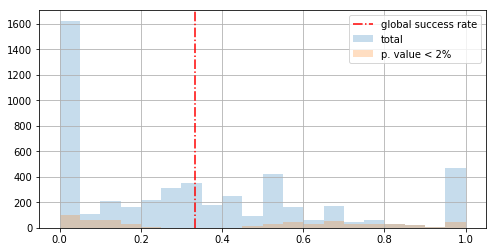

In [32]:
plt.figure(figsize=(8,4))
dfs.groupby('officerID').target.mean().hist(bins=20, alpha=0.25, label='total')
dfs_by_officerID.loc[dfs_by_officerID.binom_test_p < 0.02, 'mean'].hist(bins=20, alpha=0.25, label='p. value < 2%')
plt.axvline(x=target_global_mean, color='r', linestyle='-.', label = 'global success rate')
plt.legend();

### Search Authorization Code

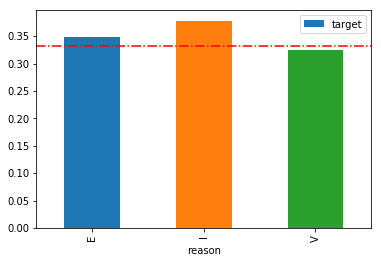

In [33]:
dfs.groupby('reason').target.mean().plot.bar()
plt.axhline(y=target_global_mean, color='r', linestyle='-.')
plt.legend();

## ('SearchAuthorizationCode': 'search_reason')

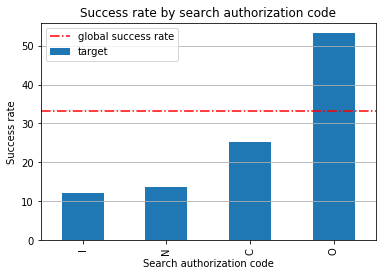

In [34]:
dfs.groupby('search_reason').target.mean().apply(lambda x: x*100).sort_values().to_frame().plot.bar(label='')

plt.axhline(y=target_global_mean*100, color='r', linestyle='-.', label='global success rate')

plt.title('Success rate by search authorization code')
plt.xlabel("Search authorization code")
plt.ylabel("Success rate")

plt.grid(axis='y')
plt.legend()

plt.savefig(os.path.join('plots', 'target_search_reason_average.png'));

## ('StatuteReason': 'stop_reason')

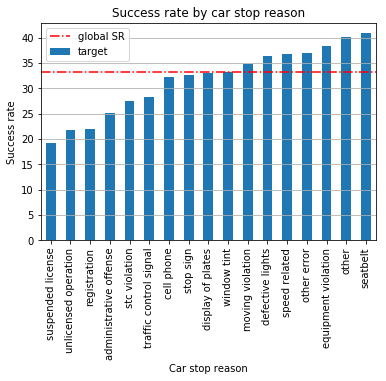

In [35]:
dfs.groupby('stop_reason').target.mean().apply(lambda x: x*100).sort_values()[1:].to_frame().plot.bar(label='')

plt.axhline(y=target_global_mean*100, color='r', linestyle='-.', label='global SR')

plt.title('Success rate by car stop reason')
plt.xlabel("Car stop reason")
plt.ylabel("Success rate")

plt.grid(axis='y')
plt.legend()

plt.savefig(os.path.join('plots', 'target_stop_reason_average.png'));

## Subject's age ('SubjectAge': 'age')

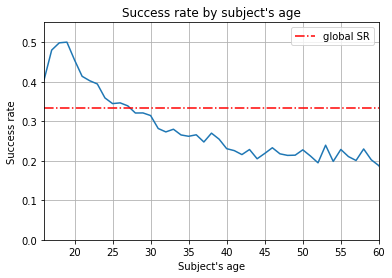

In [36]:
dfs.groupby('age').target.mean().plot(label='')

plt.axhline(y=target_global_mean, color='r', linestyle='-.', label='global SR')

plt.title("Success rate by subject's age")
plt.xlabel("Subject's age")
plt.ylabel("Success rate")

plt.xlim(16,60)
plt.ylim(0,0.55)

plt.legend()

plt.grid()

plt.savefig(os.path.join('plots', 'target_age_average.png'));

In [37]:
dfs.groupby('age').target.count().sum()

76743

In [38]:
bins=list(range(0,80,5))
bins

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75]

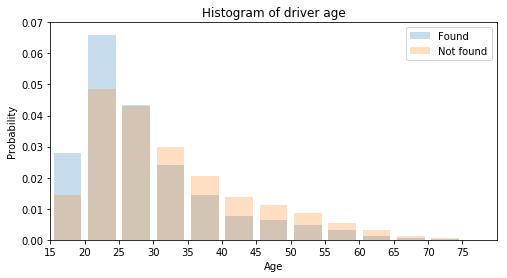

In [39]:
dfs[dfs.target==True].age.plot.hist( bins=range(0,80,5), figsize=(8,4), align='mid', rwidth=0.8, label='Found', density=True, alpha=0.25)
dfs[dfs.target==False].age.plot.hist( bins=range(0,80,5), figsize=(8,4), align='mid', rwidth=0.8, label='Not found', density=True, alpha=0.25)

plt.ylim(0, 0.07)
plt.xlim(15, 80)

plt.xticks(range(15,80,5))

plt.title('Histogram of driver age')
plt.xlabel("Age")
plt.ylabel("Probability")

plt.legend();

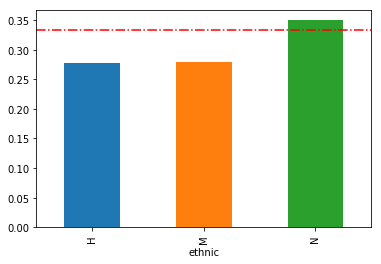

In [40]:
dfs.groupby('ethnic').target.mean().plot.bar()
plt.axhline(y=target_global_mean, color='r', linestyle='-.');

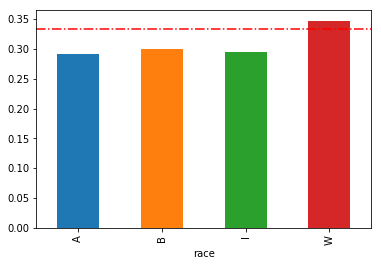

In [41]:
dfs.groupby('race').target.mean().plot.bar()
plt.axhline(y=target_global_mean, color='r', linestyle='-.');

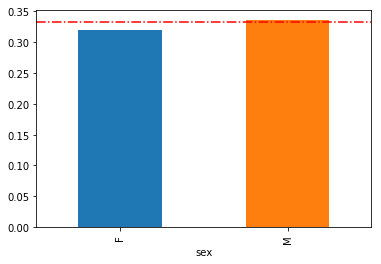

In [42]:
dfs.groupby('sex').target.mean().plot.bar()
plt.axhline(y=target_global_mean, color='r', linestyle='-.');

## 'ResidentIndicator': 'state_res'

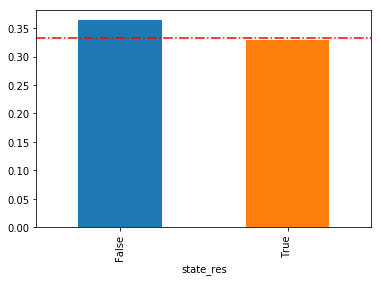

In [43]:
dfs.groupby('state_res').target.mean().plot.bar()
plt.axhline(y=target_global_mean, color='r', linestyle='-.');

## 'TownResidentIndicator': 'town_res'

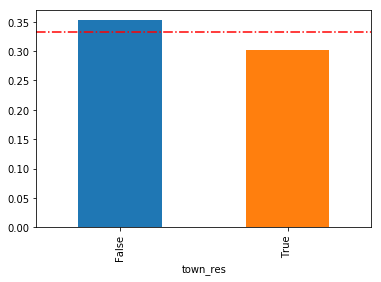

In [44]:
dfs.groupby('town_res').target.mean().plot.bar()
plt.axhline(y=target_global_mean, color='r', linestyle='-.');

### 'TownResidentIndicator' and 'ResidentIndicator' together

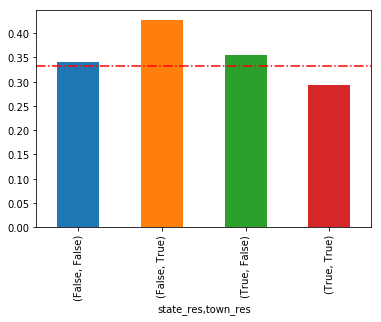

In [45]:
dfs.groupby(['state_res','town_res']).target.mean().plot.bar()
plt.axhline(y=target_global_mean, color='r', linestyle='-.');

In [46]:
dfs.groupby(['state_res','town_res']).target.count()

state_res  town_res
False      False        4849
           True         1845
True       False       41415
           True        28634
Name: target, dtype: int64

## 'InterventionDateTime': 'date'

In [47]:
dfs['dayofweek'] = dfs.date.dt.dayofweek

In [48]:
dfs['hour'] = dfs.date.dt.hour

In [49]:
dfs['month'] = dfs.date.dt.month

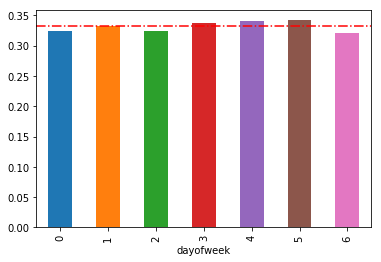

In [50]:
dfs.groupby('dayofweek').target.mean().plot.bar()
plt.axhline(y=target_global_mean, color='r', linestyle='-.');

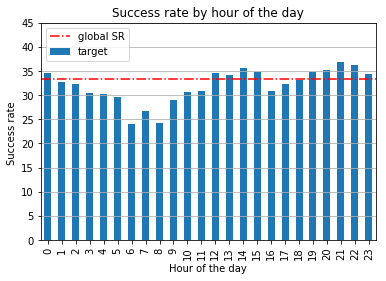

In [51]:
dfs.groupby('hour').target.mean().apply(lambda x: x*100).to_frame().plot.bar(label='')
plt.axhline(y=target_global_mean*100, color='r', linestyle='-.', label='global SR')

plt.title("Success rate by hour of the day")
plt.xlabel("Hour of the day")
plt.ylabel("Success rate ")

plt.ylim(0,45)

plt.legend(loc='upper left')
plt.grid(axis='y')

plt.savefig(os.path.join('plots', 'target_day_hour_average.png'));

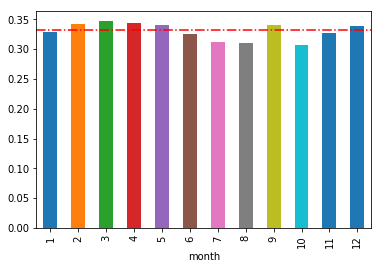

In [52]:
dfs.groupby('month').target.mean().plot.bar()
plt.axhline(y=target_global_mean, color='r', linestyle='-.');

# Previous analysis

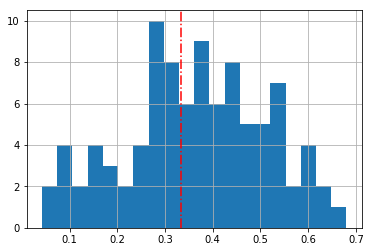

In [53]:
(dfs.groupby('departm')
    .filter(lambda x: x.shape[0]>100)
    .groupby('departm')
    .target.mean()
).hist(bins=20)
plt.axvline(x=target_global_mean, color='r', linestyle='-.');

In [54]:
dfs_by_local = dfs.groupby('local').target.agg(['mean','count'])

#average_number_of_searches = dfs_by_local['count'].mean()
average_number_of_searches = dfs.shape[0]/df.local.nunique()

dfs_by_local['weight'] = dfs_by_local['count']/average_number_of_searches
#dfs_by_local['count'] = dfs_by_local['count']/total_stops
#dfs_by_local['mean'] = dfs_by_local['mean']*dfs_by_local['count'] 

dfs_by_local['weight_mean'] = dfs_by_local['mean']*dfs_by_local['weight']*100

dfs_by_local.head()

,mean,count,weight,weight_mean
local,,,,
106,0.181818,11,0.215003,3.909151
152 name,1.000000,1,0.019546,1.954576
419,0.000000,1,0.019546,0.000000
`,1.000000,2,0.039092,3.909151
albert st,0.000000,1,0.019546,0.000000


In [55]:
dfs_by_local['weight_mean'].describe()

count     267.000000
mean      186.804726
std       373.461640
min         0.000000
25%         1.954576
50%        31.273211
75%       182.752824
max      2822.407255
Name: weight_mean, dtype: float64

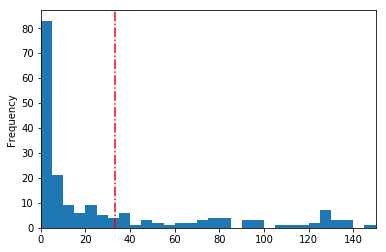

In [56]:
dfs_by_local['weight_mean'].plot.hist(xlim=(0,150), bins=range(0,200,5))
plt.axvline(x=target_global_mean*100, color='r', linestyle='-.');

No handles with labels found to put in legend.


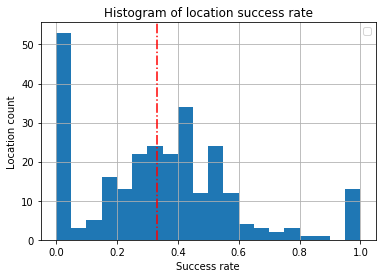

In [57]:
dfs.groupby('local').target.mean().hist(bins=20)
plt.axvline(x=target_global_mean, color='r', linestyle='-.')

#plt.ylim(0, 0.07)
#plt.xlim(15, 80)

#plt.xticks(range(15,80,5))

plt.title('Histogram of location success rate')
plt.xlabel("Success rate")
plt.ylabel("Location count")

plt.legend();

In [58]:
dfs.groupby('sex')['target'].mean()

sex
F    0.319627
M    0.335402
Name: target, dtype: float64

In [59]:
dfs.groupby('sex').filter(lambda x: x.target.mean() > 0.33)

,index,search,target,departm,date,local,reason,officerID,state_res,search_reason,stop_reason,age,ethnic,race,sex,town_res,dayofweek,hour,month
0,71,True,False,bridgeport,2013-10-01 00:46:00,bridgeport,V,1207,True,I,speed related,37.0,H,W,M,True,1,0,10
1,143,True,True,milford,2013-10-01 01:50:00,milford,E,2325,True,I,defective lights,30.0,N,W,M,True,1,1,10
2,184,True,False,torrington,2013-10-01 03:49:00,torrington,V,DACYR048,True,C,registration,43.0,N,W,M,True,1,3,10
3,203,True,False,state police,2013-10-01 05:30:00,tolland,V,1000002715,False,C,other,19.0,N,B,M,False,1,5,10
4,212,True,False,greenwich,2013-10-01 05:47:00,riverside,V,110993,False,N,speed related,34.0,M,B,M,False,1,5,10
5,252,True,True,state police,2013-10-01 06:36:00,hampton,V,1000002605,True,O,other,22.0,N,B,M,False,1,6,10
7,399,True,True,milford,2013-10-01 09:04:00,milford,V,2459,True,N,speed related,59.0,N,W,M,False,1,9,10
9,577,True,False,middletown,2013-10-01 11:05:00,middletown,V,193,True,C,other,21.0,N,W,M,False,1,11,10
10,708,True,False,naugatuck,2013-10-01 12:40:00,naugatuck,V,PL22,True,O,display of plates,29.0,N,B,M,False,1,12,10
11,709,True,True,state police,2013-10-01 12:41:00,bridgeport,V,1000001904,True,O,registration,20.0,N,B,M,True,1,12,10
